In [18]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from lib.train import gridsearch_inputer
from lib.prepare_data import make_cut, to_categorical

In [19]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [20]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [21]:
# name the important datasets and cast to type
training_tremi = dataframes["pred_tremi_full"].withColumns(
    {
        "surface": F.col("surface").cast("float"),
        "heating_production": F.col("heating_production").cast("float"),
    }
)

dictionary = dataframes["dictionary"]

In [22]:
from copy import deepcopy
from sklearn.model_selection import ShuffleSplit
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
from lib.show import score_plot
from lib.prepare_data import get_predict_set

In [23]:
# prepare data
truth = (
    training_tremi.filter(
        (F.col("surface").isNotNull()) & (F.col("heating_production").isNotNull())
    )
    .toPandas()
    .to_numpy()
)

training = deepcopy(truth)

# put null values for testing set
split = ShuffleSplit(n_splits=2, random_state=42, test_size=0.4).split(truth)
list_split = list(split)

for i, (_, test_index) in enumerate(list_split):
    for index in test_index:
        training[index][-(i + 1)] = np.nan

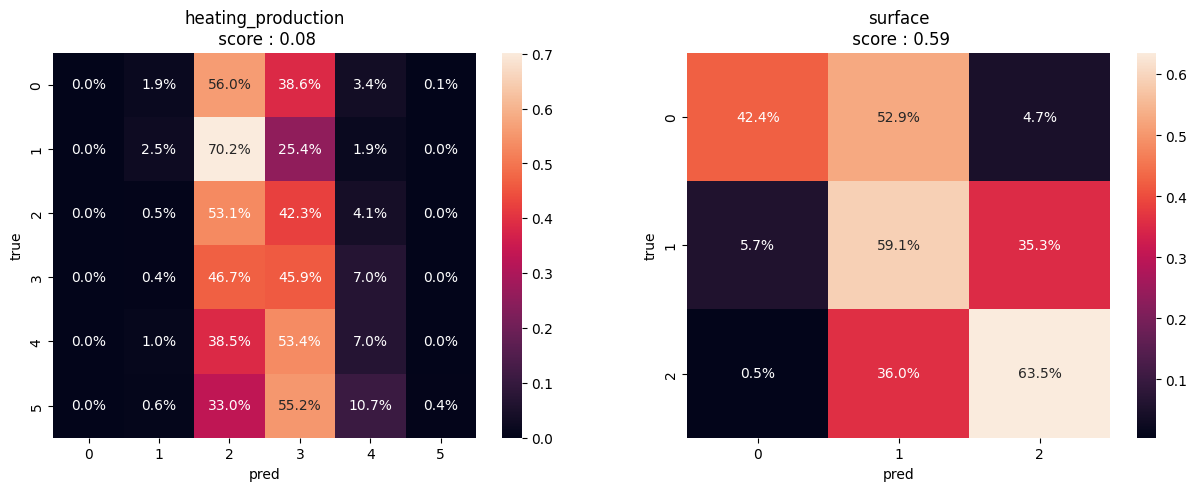

In [24]:
# fill the blanks with iterative imputer
imp = IterativeImputer(
    max_iter=10,
    random_state=42,
    min_value=[-np.inf for _ in range(15)] + [0, 1],
    max_value=[np.inf for _ in range(15)] + [np.inf, 6],
)
pred = imp.fit_transform(training)

y_true = get_predict_set(truth, list_split)
y_pred = np.rint(get_predict_set(pred, list_split))

score_plot(y_pred, y_true, ["heating_production", "surface"])

14


5
10
0.40955170083352105 {'weights': 'uniform', 'n_neighbors': 1}


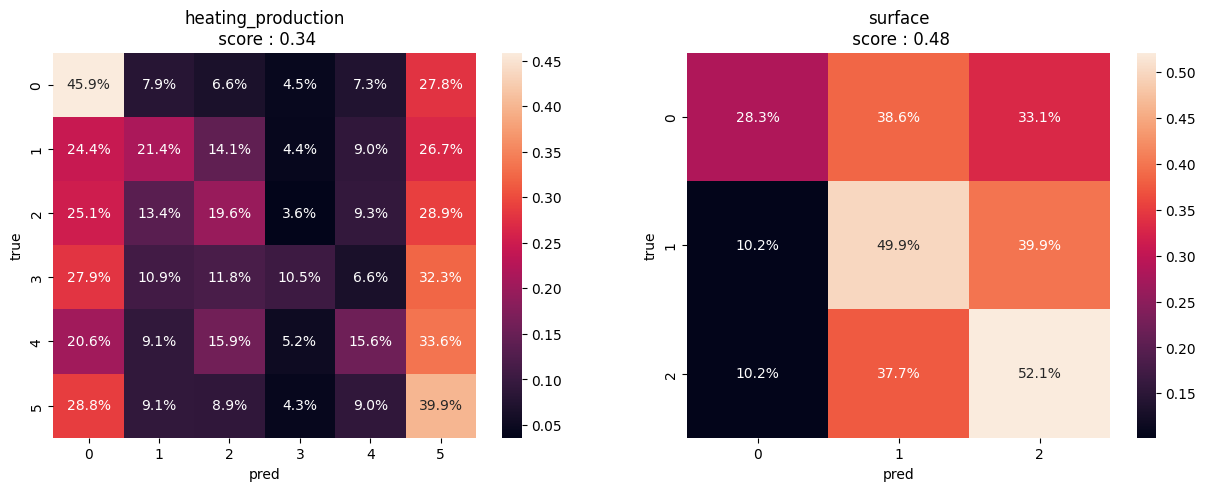

In [25]:
# do the same with knn
hyperparams = {
    "weights": ["uniform", "distance"],
    "n_neighbors": [i for i in range(1, 8)],
}
scores, max_score, best_params = gridsearch_inputer(
    KNNImputer, hyperparams, training, truth, list_split
)

knn = KNNImputer(**best_params)
pred = knn.fit_transform(training)
y_true = get_predict_set(truth, list_split)
y_pred = np.rint(get_predict_set(pred, list_split))
score_plot(y_pred, y_true, ["heating_production", "surface"])